# The Predictability of COVID-19 Cases in US Nursing Homes

The focus of this project is to identify factors that cause COVID-19 outbreaks in nursing homes and to provide an exemplary concept for the application of the findings using machine learning algorithms to allow future research to derive appropriate countermeasures for practice.

## 1 Import Python Libraries

In [1]:
# Ignoring all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from numpy import mean, std
import pandas as pd

import datetime
import ipywidgets as widgets
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

Using TensorFlow backend.


In [3]:
# Adjusting the visualisation settings of Pandas
pd.options.display.float_format = "{:.4f}".format
pd.set_option('display.max_columns', 50)

# Calling one of IPython's predefined ‘magic functions’ to include matplotlib graphs in notebook
%matplotlib inline

## 2 Load Data Sets with Pre-selected Features into Pandas

### 2.1 Provider Info

General information on currently active nursing homes, including number of certified beds, quality measure scores, staffing and other information used in the Five-Star Rating System. Data are presented as one row per nursing home.

Data Retreived: August 20, 2020

Source: https://data.medicare.gov/Nursing-Home-Compare/Provider-Info/4pq5-n9py

In [4]:
df_nh = pd.read_csv("01_Original Data/Provider_Info.csv",usecols=['Federal Provider Number',
                                                                  'Provider Zip Code',
                                                                  'Ownership Type',
                                                                  'Date First Approved to Provide Medicare and Medicaid services',
                                                                  'Overall Rating', 
                                                                  'Reported RN Staffing Hours per Resident per Day',
                                                                  'Reported Total Nurse Staffing Hours per Resident per Day',
                                                                  'Total Amount of Fines in Dollars'])

df_nh.rename(columns={'Federal Provider Number':'provider_number',
                      'Provider Zip Code':'zip_code',
                      'Ownership Type':'ownership',
                      'Overall Rating':'rating',
                      'Total Amount of Fines in Dollars':'total_fine',
                      'Reported RN Staffing Hours per Resident per Day':'rn_staff',
                      'Reported Total Nurse Staffing Hours per Resident per Day':'total_staff',
                      'Date First Approved to Provide Medicare and Medicaid services':'approved_date'},inplace=True)

### 2.2 COVID-19 Nursing Home Data Set

The Nursing Home COVID-19 Public File includes data reported by nursing homes to the CDC’s National Healthcare Safety Network (NHSN) system COVID-19 Long Term Care Facility Module, including Resident Impact, Facility Capacity, Staff & Personnel, and Supplies & Personal Protective Equipment, and Ventilator Capacity and Supplies Data Elements.

Data Retreived: August 20, 2020

Source: https://data.cms.gov/Special-Programs-Initiatives-COVID-19-Nursing-Home/COVID-19-Nursing-Home-Dataset/s2uc-8wxp

In [5]:
df_nh_covid = pd.read_csv("01_Original Data/COVID-19_Nursing_Home_Dataset.csv",usecols=['Week Ending',
                                                                                        'Passed Quality Assurance Check',
                                                                                        'Federal Provider Number',
                                                                                        'Residents Total Confirmed COVID-19',
                                                                                        'Residents Total COVID-19 Deaths',
                                                                                        'Number of All Beds',
                                                                                        'Total Number of Occupied Beds',
                                                                                        'Staff Total Confirmed COVID-19',
                                                                                        'Staff Total COVID-19 Deaths'])

df_nh_covid.rename(columns={'Federal Provider Number':'provider_number',
                            'Residents Total Confirmed COVID-19':'total_inf_res',
                            'Residents Total COVID-19 Deaths':'total_inf_staff',
                            'Staff Total Confirmed COVID-19':'total_deaths_res',
                            'Staff Total COVID-19 Deaths':'total_deaths_staff',
                            'Number of All Beds':'total_beds',
                            'Total Number of Occupied Beds':'occupied_beds'},inplace=True)

### 2.3 Deficiencies Displayed on Nursing Home Compare

A list of all health deficiencies currently listed on Nursing Home Compare including the most recent comprehensive inspection and the most recent 36 months of complaint inspections.

Data Retreived: August 20, 2020

Source: https://data.medicare.gov/Nursing-Home-Compare/Deficiencies-Displayed-on-Nursing-Home-Compare-Cyc/np3k-uatv

Source: https://data.medicare.gov/Nursing-Home-Compare/Deficiencies-Displayed-on-Nursing-Home-Compare-Cyc/3j8m-gmpk

Source: https://data.medicare.gov/Nursing-Home-Compare/Deficiencies-Displayed-on-Nursing-Home-Compare-Cyc/7gue-kitf

In [6]:
df_def1 = pd.read_csv("01_Original Data/Deficiencies_Cycle_1.csv",usecols=['Federal Provider Number', 
                                                                           'Scope Severity Code',
                                                                           'Deficiency Description'])

df_def2 = pd.read_csv("01_Original Data/Deficiencies_Cycle_2.csv",usecols=['Federal Provider Number', 
                                                                           'Scope Severity Code',
                                                                           'Deficiency Description'])

df_def3 = pd.read_csv("01_Original Data/Deficiencies_Cycle_3.csv",usecols=['Federal Provider Number', 
                                                                           'Scope Severity Code',
                                                                           'Deficiency Description'])

df_def1.rename(columns={'Federal Provider Number':'provider_number'},inplace=True)
df_def2.rename(columns={'Federal Provider Number':'provider_number'},inplace=True)
df_def3.rename(columns={'Federal Provider Number':'provider_number'},inplace=True)

### 2.4 LTCFocus.org Data Set

LTCFocus.org is a product of the Shaping Long-Term Care in America Project being conducted at the Brown University Center for Gerontology and Healthcare Research and supported, in part, by the National Institute on Aging. The website hosts data regarding the health and functional status of nursing home residents, characteristics of care facilities, state policies relevant to long term care services and financing, and data characterizing the markets in which facilities exist and, in the future, we plan to expand to include information about other sectors of the long-term care system.

Data Retreived: August 20, 2020

Source: http://ltcfocus.org/download/13f2aa4c-7145-7b6c-f2ad-dc8e59bf86d9

In [7]:
df_res = pd.read_csv("01_Original Data/facility_2017.csv",delimiter=';',usecols=['PROV1680',
                                                                                 'state',
                                                                                 'county',
                                                                                 'paymcaid',
                                                                                 'multifac',
                                                                                 'pctwhite_2011p'])

df_res.rename(columns={'PROV1680':'provider_number'},inplace=True)

### 2.5 USAFacts.org County-level Tracker

The county-level tracker makes it easy to follow COVID-19 cases on a granular level, as does the ability to break down infections per 100,000 people.

Data Last Updated: August 20, 2020

Source: https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/Source: 

In [8]:
df_county_cases = pd.read_csv("01_Original Data/covid_confirmed_usafacts.csv")

df_county_deaths = pd.read_csv("01_Original Data/covid_deaths_usafacts.csv")

df_county_population = pd.read_csv("01_Original Data/covid_county_population_usafacts.csv",usecols=['countyFIPS',
                                                                                                    'population'])

### 2.6 Two-Digit State Code Listing (manually created) 

Geographic Reference Files are documents that list codes for geographic entities.

Data Retreived: August 20, 2020

Based on: https://www.census.gov/data/datasets/1997/econ/gus/gidstate.html

In [9]:
df_county_key1 = pd.read_excel("01_Original Data/state_code.xlsx")

### 2.7 US Zipcodes to County State (manually created)

Databases of U.S. zip codes and their associated county code.

Data Retreived: August 20, 2020

Based on: https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt

In [10]:
zip_to_county = pd.read_excel("01_Original Data/zip_to_county.xlsx")

### 2.8 SSA and FIPS County Codes

CMS periodically produces SSA to FIPS state and county crosswalk files. Some CMS data files have SSA state and county codes or county name rather than FIPS state and county codes. The data files below are processed to be easier for SAS and Stata use.

Data Retreived: August 20, 2020

Source: http://data.nber.org/data/ssa-fips-state-county-crosswalk.html

In [11]:
df_county_key2 = pd.read_excel("01_Original Data/FY 2017 FR Cty CBSA Xwalk and CBSA Con Cty.xlsx",
                               usecols=['FIPS State county code',
                                        'CBSA (Blanks are Rural)'])

df_county_key2.rename(columns={'FIPS State county code':'fips',
                               'CBSA (Blanks are Rural)':'cbsa_code'},inplace=True)

## 3 Data Pre-Processing

### 3.1 COVID-19 Nursing Home Dataset

In [12]:
# Converting the column Week Ending in a date format
df_nh_covid['Week Ending'] = pd.to_datetime(df_nh_covid['Week Ending']).dt.date

# Selecting the most recent date
max_date_filter = df_nh_covid['Week Ending'].max()

# Filtering LTC facilities out that did not pass the quality assuance check
df_nh_covid = df_nh_covid[df_nh_covid['Passed Quality Assurance Check']=='Y']

# Assigning the most recent date as a default for the dropdown function
new_date = max_date_filter

# Creating a dropdown function which allows to select a range of available dates
dropdown_date = widgets.Dropdown(options=sorted(df_nh_covid['Week Ending'].unique(),reverse=True))

input_date_filter = widgets.Output()

def dropdown_date_eventhandler(change):
    input_date_filter.clear_output()
    with input_date_filter:
        if (change.new==new_date):
            display(max_date_filter)
        else:
            display(change.new)

dropdown_date.observe(dropdown_date_eventhandler,names='value')

display(dropdown_date)

Dropdown(options=(datetime.date(2020, 8, 2), datetime.date(2020, 7, 26), datetime.date(2020, 7, 19), datetime.…

In [13]:
# Keeping only the data entries with the selected date (by default the most recent date)
date_selected = dropdown_date.value
df_nh_covid = df_nh_covid[df_nh_covid['Week Ending']==date_selected]

# Dropping the columns 'Week Ending' and 'Passed Quality Assurance Check'
df_nh_covid= df_nh_covid.drop(['Week Ending','Passed Quality Assurance Check'],axis=1)

### 3.2 Deficiencies Displayed on Nursing Home Compare

In [14]:
# Merging the three deficiencies tables into one new data frame
df_def = df_def1.append(df_def2)
df_def = df_def.append(df_def3)

# Deleting the old data frames
del df_def1,df_def2,df_def3

In [15]:
# Categorising the severity codes into federal and serious federal deficiencies
df_def.loc[df_def['Scope Severity Code'].isin(['B','C','D','E','F']),'fed_def'] = 1
df_def.loc[df_def['Scope Severity Code'].isin(['G','H','I','J','K']),'serious_fed_def'] = 1

# Creating a new deficiency type for implementing appropriate infection prevention measures based the deficiency description
df_def.loc[df_def['Deficiency Description'].isin([
    'Provide and implement an infection prevention and control program.']),'infection_def'] = 1

df_def = df_def[df_def['Scope Severity Code'].isin(['B','C','D','E','F','G','H','I','J','K'])]

# Grouping the number of deficiencies bye nursing homes 
df_def = df_def.groupby(['provider_number'])[['fed_def','serious_fed_def','infection_def']].sum().reset_index()


### 3.3 LTCFocus.org Data Set

In [16]:
# Attaching the state_code to the LTCFocus.org Data Set
df_res = pd.merge(df_res,df_county_key1,how='inner',on='state')

# Converting the county and state_code columns into three and two character long strings
df_res['county'] = df_res['county'].apply(lambda x: '{0:0>3}'.format(x))
df_res['state_code'] = df_res['state_code'].apply(lambda x: '{0:0>2}'.format(x))
df_res['state_code'] = df_res['state_code'].astype(str)
df_res['county'] = df_res['county'].astype(str)

# Combining the two columns into a new column county_code
df_res['county_code'] = df_res['state_code'] + df_res['county']

# Dropping the old columns
df_res = df_res.drop(['state','county','state_code'],axis=1)

### 3.4 USAFacts.org County-level Tracker

In [17]:
# Converting date format from dropdown function into the same format as the columns in the county cases and deaths data sets
timestampStr = date_selected.strftime('X%m/X%d/%y').replace('X0','X').replace('X','')

# Keeping only the county cases and deaths from the date selected in the dropdown
df_county_cases.drop(df_county_cases.columns.difference(['countyFIPS',
                                                         timestampStr]),1,inplace=True)
df_county_deaths.drop(df_county_deaths.columns.difference(['countyFIPS',
                                                           timestampStr]),1,inplace=True)

# Dropping unallocated cases and deaths as they can not be assigned to a specific county
df_county_cases = df_county_cases[df_county_cases['countyFIPS']!=0]
df_county_population = df_county_population[df_county_population['countyFIPS']!=0]
df_county_deaths = df_county_deaths[df_county_deaths['countyFIPS']!=0]

# Merging the three County-level Tracker tables into one new data frame
df_county_combined = pd.merge(df_county_population,df_county_cases,how='left',on=['countyFIPS'])
df_county_combined = pd.merge(df_county_combined,df_county_deaths,how='left',on=['countyFIPS'])

# Renaming the columns in the newly created data frame
df_county_combined.columns = ['countyFIPS',
                              'population',
                              'confirmed',
                              'deaths']

## 4 Data Mapping

In [18]:
# Taking the Provider Info data frame as basis for further processing 
df_merged = df_nh.copy()

# Mapping the COVID-19 Nursing Home data set to the newly created data frame
df_merged = pd.merge(df_merged,df_nh_covid[['provider_number',
                                            'total_inf_res',
                                            'total_inf_staff',
                                            'total_beds',
                                            'occupied_beds',
                                            'total_deaths_res',
                                            'total_deaths_staff']]
                   ,how='left',on=['provider_number'])

# Rounding the reported staffing hours per resident per days 
df_merged['rn_staff'] = (df_merged['rn_staff']).round(2)
df_merged['total_staff'] = (df_merged['total_staff']).round(2)

In [19]:
# Mapping the Deficiencies Displayed on Nursing Home Compare data set to the newly created data frame
df_merged = pd.merge(df_merged,df_def,how='left',on=['provider_number'])

In [20]:
# Mapping the LTCFocus.org data set to the newly created data frame
df_merged = pd.merge(df_merged,df_res[['provider_number',
                                       'paymcaid',
                                       'multifac',
                                       'pctwhite_2011p',
                                       'county_code']]
                   ,how='left',on=['provider_number'])

In [21]:
# Converting the county_code column to numeric values
df_merged['county_code'] = pd.to_numeric(df_merged['county_code'],errors='coerce')

# Mapping the SSA and FIPS County Codes data set to the newly created data frame
df_merged = pd.merge(df_merged,df_county_key2,how='left',left_on=['county_code'],right_on=['fips'])

# Dropping the fips column
df_merged = df_merged.drop(['fips'],axis=1)

In [22]:
# Mapping the USAFacts.org County-level Tracker data set to the newly created data frame
df_merged = pd.merge(df_merged,df_county_combined[['countyFIPS',
                                                   'population',
                                                   'confirmed',
                                                   'deaths']]
                   ,how='left',left_on=['county_code'],right_on=['countyFIPS'])

# Dropping the countyFIPS column
df_merged = df_merged.drop(['countyFIPS'],axis=1)

## 5 Data Preparation

### 5.1 Missing Value Treatment

#### 5.1.1 Identify Missing Values

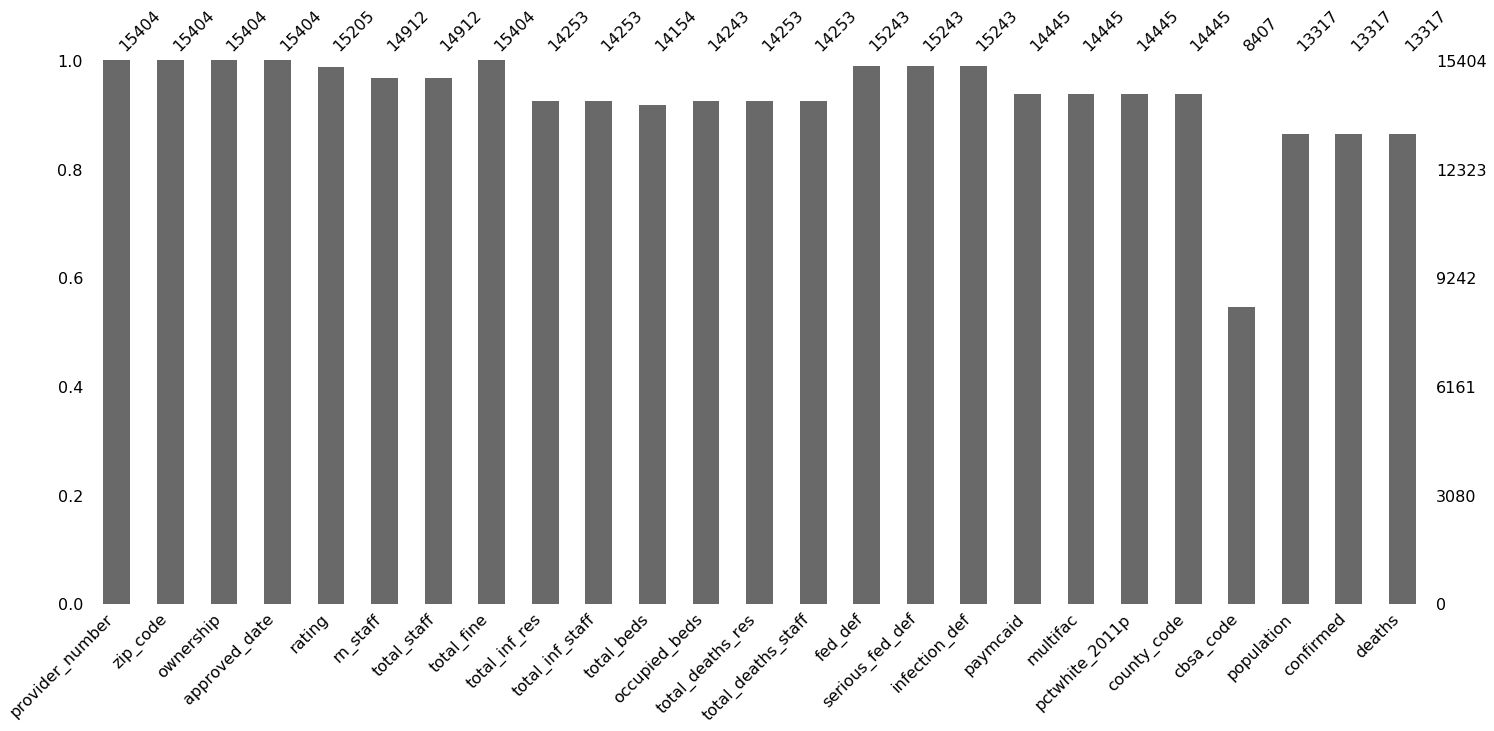

In [23]:
# Illustrating the missing values in each column
msno.bar(df_merged)

In [24]:
# Printing the number of missing entries for each column
df_merged.isnull().sum()

provider_number          0
zip_code                 0
ownership                0
approved_date            0
rating                 199
rn_staff               492
total_staff            492
total_fine               0
total_inf_res         1151
total_inf_staff       1151
total_beds            1250
occupied_beds         1161
total_deaths_res      1151
total_deaths_staff    1151
fed_def                161
serious_fed_def        161
infection_def          161
paymcaid               959
multifac               959
pctwhite_2011p         959
county_code            959
cbsa_code             6997
population            2087
confirmed             2087
deaths                2087
dtype: int64

In [25]:
# Printing the data types of each column
df_merged.dtypes

provider_number        object
zip_code                int64
ownership              object
approved_date          object
rating                float64
rn_staff              float64
total_staff           float64
total_fine              int64
total_inf_res         float64
total_inf_staff       float64
total_beds            float64
occupied_beds          object
total_deaths_res      float64
total_deaths_staff    float64
fed_def               float64
serious_fed_def       float64
infection_def         float64
paymcaid              float64
multifac               object
pctwhite_2011p         object
county_code           float64
cbsa_code             float64
population            float64
confirmed             float64
deaths                float64
dtype: object

#### 5.1.2 Overall Rating (Provider Info)

In [26]:
# Creating a new data frame with only missing values in the respective column 
no_rating = df_merged.copy()
no_rating = no_rating[(no_rating['rating'].isnull())]

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_rating['provider_number'])]

# Filling the missing values in the no_rating data frame with the median of the respective value from the main data frame
rating_median = df_merged['rating'].median()
no_rating['rating'] = no_rating['rating'].fillna(rating_median)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_rating)

# Rounding the column rating to convert it from a float to an integer
df_merged['rating'] = df_merged['rating'].round()

# Printing the number of entries the applied method filled
print(no_rating.rating.notnull().sum())

199


#### 5.1.3 Reported RN Staffing Hours per Resident per Day (Provider Info)

In [27]:
# Creating a new data frame with only missing values in the respective column 
no_rn_staff = df_merged.copy()
no_rn_staff = no_rn_staff[(no_rn_staff['rn_staff'].isnull())]

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_rn_staff['provider_number'])]

# Filling the missing values in the rn_staff data frame with the median of the respective value from the main data frame
rn_staff_median = df_merged['rn_staff'].median()
no_rn_staff['rn_staff'] = no_rn_staff['rn_staff'].fillna(rn_staff_median)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_rn_staff)

# Printing the number of entries the applied method filled
print(no_rn_staff.rn_staff.notnull().sum())

492


#### 5.1.4 Reported Total Nurse Staffing Hours per Resident per Day (Provider Info)

In [28]:
# Creating a new data frame with only missing values in the respective column 
no_total_staff = df_merged.copy()
no_total_staff = no_total_staff[(no_total_staff['total_staff'].isnull())]

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_total_staff['provider_number'])]

# Filling the missing values in the total_staff data frame with the median of the respective value from the main data frame
total_staff_median = df_merged['total_staff'].median()
no_total_staff['total_staff'] = no_total_staff['total_staff'].fillna(total_staff_median)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_total_staff)

# Printing the number of entries the applied method filled
print(no_total_staff.total_staff.notnull().sum())

492


#### 5.1.5 Number of All Beds (COVID-19 Nursing Home Dataset)

In [29]:
# Creating a new data frame with only missing values in the respective column 
no_total_beds = df_merged.copy()
no_total_beds = no_total_beds[(no_total_beds['total_beds'].isnull())]

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_total_beds['provider_number'])]

# Filling the missing values in the total_beds data frame with the median of the respective value from the main data frame
total_beds_median = df_merged['total_beds'].median()
no_total_beds['total_beds'] = no_total_beds['total_beds'].fillna(total_beds_median)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_total_beds)

# Printing the number of entries the applied method filled
print(no_total_beds.total_beds.notnull().sum())

1250


#### 5.1.6 Total Number of Occupied Beds (COVID-19 Nursing Home Dataset)

In [30]:
# Converting the column occupied_beds from an object to numeric values
df_merged['occupied_beds'] = pd.to_numeric(df_merged['occupied_beds'],errors='coerce')

# Creating a new data frame with only missing values in the respective column 
no_occupied_beds = df_merged.copy()
no_occupied_beds = no_occupied_beds[(no_occupied_beds['occupied_beds'].isnull())]

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_occupied_beds['provider_number'])]

# Filling the missing values in the occupied_beds data frame with the median of the respective value from the main data frame
occupied_beds_median = df_merged['occupied_beds'].median()
no_occupied_beds['occupied_beds'] = no_occupied_beds['occupied_beds'].fillna(occupied_beds_median)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_occupied_beds)

# Printing the number of entries the applied method filled
print(no_occupied_beds.occupied_beds.notnull().sum())

1162


#### 5.1.7 Deficiencies Displayed on Nursing Home Compare

In [31]:
# Replacing missing values in the deficiency columns with 0s 
df_merged[['fed_def','serious_fed_def','infection_def']] = df_merged[['fed_def','serious_fed_def','infection_def']].fillna(value=0)

#### 5.1.8 paymcaid (LTCFocus.org Data Set)

In [32]:
# Creating a new data frame with only missing values in the respective column 
no_paymcaid = df_merged.copy()
no_paymcaid = no_paymcaid[(no_paymcaid['paymcaid'].isnull())]

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_paymcaid['provider_number'])]

# Filling the missing values in the paymcaid data frame with the median of the respective value from the main data frame
paymcaid_median = df_merged['paymcaid'].median()
no_paymcaid['paymcaid'] = no_paymcaid['paymcaid'].fillna(paymcaid_median)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_paymcaid)

# Printing the number of entries the applied method filled
print(no_paymcaid.paymcaid.notnull().sum())

959


#### 5.1.9 multifac (LTCFocus.org Data Set)

In [33]:
# Creating a new data frame with only missing values in the respective column 
no_multifac = df_merged.copy()
no_multifac = no_multifac[(no_multifac['multifac'].isnull())]

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_multifac['provider_number'])]

# Converting the multifac column into binary values
df_merged['multifac'] = np.where(df_merged['multifac']=='Yes',1,0)

# Filling the missing values in the multifac data frame with the median of the respective value from the main data frame
multifac_median = df_merged['multifac'].median()
no_multifac['multifac'] = no_multifac['multifac'].fillna(multifac_median)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_multifac)

# Printing the number of entries the applied method filled
print(no_multifac.multifac.notnull().sum())

959


#### 5.1.10 pctwhite_2011p (LTCFocus.org Data Set)

In [34]:
# Converting the column pctwhite_2011p from an object to numeric values
df_merged['pctwhite_2011p'] = pd.to_numeric(df_merged['pctwhite_2011p'],errors='coerce')

# Creating a new data frame with only missing values in the respective column 
no_pctwhite_2011p = df_merged.copy()
no_pctwhite_2011p = no_pctwhite_2011p[(no_pctwhite_2011p['pctwhite_2011p'].isnull())]

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_pctwhite_2011p['provider_number'])]

# Filling the missing values in the pctwhite_2011p data frame with the median of the respective value from the main data frame
pctwhite_2011p_median = df_merged['pctwhite_2011p'].median()
no_pctwhite_2011p['pctwhite_2011p'] = no_pctwhite_2011p['pctwhite_2011p'].fillna(pctwhite_2011p_median)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_pctwhite_2011p)

# Printing the number of entries the applied method filled
print(no_pctwhite_2011p.pctwhite_2011p.notnull().sum())

1458


#### 5.1.11 USAFacts.org County-level Tracker

In [35]:
# Creating a new data frame with only missing values in the respective column but not missing values in the column county_code
no_county = df_merged.copy()
no_county = no_county[(~no_county['county_code'].isnull())&(no_county['population'].isnull())]

# Dropping the columns with missing values
no_county = no_county.drop(['county_code','population','confirmed','deaths'],axis=1)

# Removing the above used entries from the main data frame
df_merged = df_merged[~df_merged['provider_number'].isin(no_county['provider_number'])]

# Dropping zip code that occur more than once and are therefore not assignable to a single county
zip_to_county.drop_duplicates(subset='zip_code',inplace=True,keep=False)

#zip_to_county.rename(columns={'zip_county_code':'county_code'},inplace=True)

# Mapping the US Zipcodes to County State data set to the no_county data frame
no_county = pd.merge(no_county,zip_to_county,how='left',on=['zip_code'])
no_county = no_county.drop(['zip_code'],axis=1)

# Rounding the column county_code to convert it from a float to an integer
no_county['county_code'] = no_county['county_code'].round()

# Mapping the USAFacts.org County-level Tracker data set to the no_county data frame
no_county = pd.merge(no_county,df_county_combined[['countyFIPS',
                                                   'population',
                                                   'confirmed',
                                                   'deaths']]
                   ,how='left',left_on=['county_code'],right_on=['countyFIPS'])

# Dropping the countyFIPS column
no_county = no_county.drop(['countyFIPS'],axis=1)

# Adding the filled data frame to the main data frame
df_merged = df_merged.append(no_county)

# Dropping the zip_code column
df_merged = df_merged.drop(['zip_code'],axis=1)

#### 5.1.12 CBSA (Blanks are Rural) (SSA and FIPS County Codes)

In [36]:
# Converting the urban column into binary values
df_merged['urban'] = np.where(~np.isnan(df_merged['cbsa_code']),1,0)

# Dropping the cbsa_code column
df_merged = df_merged.drop(['cbsa_code'],axis=1)

#### 5.1.12 Drop remaining LTC Facilities with Missing Values

In [37]:
#df_merged = df_merged.drop_duplicates()
df_merged = df_merged.dropna()

In [38]:
# Printing the number of rows and columns in the data frame
df_merged.shape

(13078, 24)

### 5.2 Feature Engineering

#### 5.2.1 Ownership Type

In [39]:
# Converting the for_profit column into binary values
df_merged['for_profit'] = np.where(df_merged['ownership'].str[:10]=='For profit',1,0)

# Dropping the cbsa_code column
df_merged= df_merged.drop(['ownership'],axis=1)

#### 5.2.2 Facility Age

In [40]:
# Calculating the years each nursing home is operating for
df_merged['approved_date'] = pd.to_datetime(df_merged['approved_date']).dt.date
df_merged['years'] = ((date_selected - df_merged['approved_date'])/np.timedelta64(1,'Y')).round(2)

# Dropping the approved_date column
df_merged = df_merged.drop(['approved_date'],axis=1)

#### 5.2.3 Bed Occupancy Rates

In [41]:
# Calculating the occupancy of beds in each nursing home
df_merged['occupancy'] = (df_merged['occupied_beds']/df_merged['total_beds']*100).round(2)

#### 5.2.4 Excess Beds per County

In [42]:
# Creating a new data frame with the columns county_code, total_beds_ and occupied_beds in order to group by the county_code
county_excess = df_merged[['county_code','total_beds','occupied_beds']]
county_excess = county_excess.groupby(['county_code']).sum().reset_index()

# Calculating a new column by subtracting the total number of beds by the total occupied beds in a county 
county_excess['county_excess'] = county_excess['total_beds'] - county_excess['occupied_beds']

# Removing nursing homes that are in a county with a negative excess of beds in a county
# (possibly caused by an error in the reporting of numbers)
county_excess = county_excess[county_excess['county_excess'] >= 0]

# Mapping the county_excess to the main data frame
df_merged = pd.merge(df_merged,county_excess[['county_code','county_excess']],how='left',on=['county_code'])

# Dropping the occupied_beds column
df_merged = df_merged.drop(['occupied_beds'],axis=1)

#### 5.2.5 Competition Metrics (Herfindahl Index)

In [43]:
# Creating a new data frame by grouping the column total_beds based on the county_code
market_share = df_merged.groupby(['county_code'])[['total_beds']].sum().reset_index()

# Renaming the sum of total_beds to sum_total_beds to avoid name collisions
market_share.rename(columns={'total_beds':'sum_total_beds'},inplace=True)

# Mapping the sum_total_beds to the main data frame
df_merged = pd.merge(df_merged,market_share[['county_code','sum_total_beds']],how='left',on=['county_code'])

# Calculating the share of the beds for each county
df_merged['beds_market'] = ((df_merged['total_beds']/df_merged['sum_total_beds'])**2)
market_share = df_merged.groupby(['county_code'])[['beds_market']].sum().reset_index()

# Renaming the sum of beds_market to sum_beds_market to avoid name collisions
market_share.rename(columns={'beds_market':'sum_beds_market'},inplace=True)

# Mapping the sum_beds_market to the main data frame
df_merged = pd.merge(df_merged,market_share[['county_code','sum_beds_market']],how='left',on=['county_code'])

# Dropping the county_code column
df_merged = df_merged.drop(['county_code'],axis=1)

# Calculating the herfindahl index
df_merged['herfindahl'] = np.where(np.isnan(df_merged['beds_market']), np.nan,df_merged['sum_beds_market'])
df_merged['herfindahl'] = (df_merged['herfindahl']*100).round(2)

# Dropping the columns sum_beds_market, sum_total_beds and beds_market
df_merged = df_merged.drop(['sum_beds_market','sum_total_beds','beds_market'],axis=1)

#### 5.2.6 Percentage of Racial and Ethnic Minority Residents  

In [44]:
# Converting the pctwhite_2011p column to numeric values
df_merged['pctwhite_2011p'] = pd.to_numeric(df_merged['pctwhite_2011p'],errors='coerce')

# Calculating share of racial and ethnic minority residents
df_merged['minority'] = 100-df_merged['pctwhite_2011p'].round(2)

# Dropping the pctwhite_2011p column
df_merged = df_merged.drop(['pctwhite_2011p'],axis=1)

#### 5.2.7 County Cases and Deaths per 100K Population

In [45]:
# Calculating the county cases and deaths on a 100K population basis for a more appropriate comparison between counties
df_merged['county_cases_100'] = (df_merged['confirmed']/df_merged['population']*100000).round(0)
df_merged['county_deaths_100'] = (df_merged['deaths']/df_merged['population']*100000).round(0)

# Dropping the columns confirmed, deaths and population
df_merged = df_merged.drop(['confirmed','deaths','population'],axis=1)

#### <font color='grey'>5.2.8 Mortality Ratios (Not used)</font>

Mortality ratios in nursing homes were dropped as features for this project due to the difficulty of their interpretation. A large share of nursing homes have mortality rates of over 100% due to the lack of adequate testing capabilities. On the one hand, the removal of nursing homes with mortality ratios above 100% is out of proportion to the added value of the features, and on the other hand does not solve the problem of difficult interpretability even with mortality rates below 100%.

#### 5.2.9 Drop remaining LTC Facilities with Missing Values

In [46]:
#df_merged = df_merged.drop_duplicates()
df_merged = df_merged.dropna()

In [47]:
# Printing the number of rows and columns in the data frame
df_merged.shape

(13070, 24)

### 5.3 Create Target Features (Dependant Variables)

In [48]:
# Setting the 95% percentile as threshold in order to classify the 5% highest cases and deaths as outbreak 
# Threshold for deaths among staff is not calculated as it would be 0; differentiation only between deaths or no deaths
inf_res_95_up = df_merged.loc[:,'total_inf_res'].quantile(0.95)
inf_staff_95_up = df_merged.loc[:,'total_inf_staff'].quantile(0.95)
deaths_res_95_up = df_merged.loc[:,'total_deaths_res'].quantile(0.95)

# Calculating the max values in the aforementioned features as a boundary for the Pandas cut function
inf_res_max = df_merged.loc[:,'total_inf_res'].max()
inf_staff_max = df_merged.loc[:,'total_inf_staff'].max()
deaths_res_max = df_merged.loc[:,'total_deaths_res'].max()

# Setting the 75% percentile as threshold in order to classify the 25% highest mortality rates as outbreak
# It is not the 95% percentile as the mortality rates above the 80% percentile already cross 100%
#res_rate_75_up = df_merged.loc[:,'res_rate'].quantile(0.75)
#staff_rate_75_up = df_merged.loc[:,'staff_rate'].quantile(0.75)

In [49]:
# Creating four different target features infections and fatalities among residents and staff (No Case, Confirmed Cases)
df_merged['inf_res'] = np.where(df_merged['total_inf_res']==0,0,1)
df_merged['inf_staff'] = np.where(df_merged['total_inf_staff']==0,0,1)
df_merged['deaths_res'] = np.where(df_merged['total_deaths_res']==0,0,1)
df_merged['deaths_staff'] = np.where(df_merged['total_deaths_staff']==0,0,1)

# Calculating target features for two mortality rates
#df_merged['res_rate_75_up'] = np.where(df_merged['res_rate']>=res_rate_75_up,1,0)
#df_merged['staff_rate_75_up'] = np.where(df_merged['staff_rate']>=staff_rate_75_up,1,0)

### 5.4 Convert Independant Variables in Binary Values (Used for the Univariate Analyses)

### 5.5 Reorder and Export Data Frames

#### 5.5.1 Main Data Frame

In [50]:
# Converting columns from a float to an integer
cols = ['rating',
        'total_fine',
        'total_inf_res',
        'total_inf_staff',
        'total_beds',
        'total_deaths_res',
        'total_deaths_staff',
        'multifac',
        'fed_def',
        'serious_fed_def',
        'infection_def',
        'county_excess',
        'county_cases_100',
        'county_deaths_100']

for cols in cols:
    df_merged[cols] = df_merged[cols].apply(lambda x: int(x) if x == x else "")

In [51]:
# Reordering the structure in the data frame
df_merged = df_merged[['inf_res',
                       'inf_staff',
                       'deaths_res',
                       'deaths_staff',
                       'total_inf_res',
                       'total_inf_staff',
                       'total_deaths_res',
                       'total_deaths_staff',
                       #'res_rate',
                       #'staff_rate',
                       'total_beds',
                       'years',
                       'for_profit',
                       'multifac',
                       'urban',
                       'occupancy',
                       'rating',
                       'fed_def',
                       'serious_fed_def',
                       'infection_def',
                       'total_fine',
                       'rn_staff',
                       'total_staff',
                       'paymcaid',
                       'minority',
                       'county_excess',
                       'herfindahl',
                       'county_cases_100',
                       'county_deaths_100',
                       #'county_rate_100'
                      ]]

#### 5.5.2 Univariate Analyses Data Frame

## 6 Describe the Data Frame

### 6.1 Generate Descriptive Statistics

### 6.2 Create Correlation Matrix

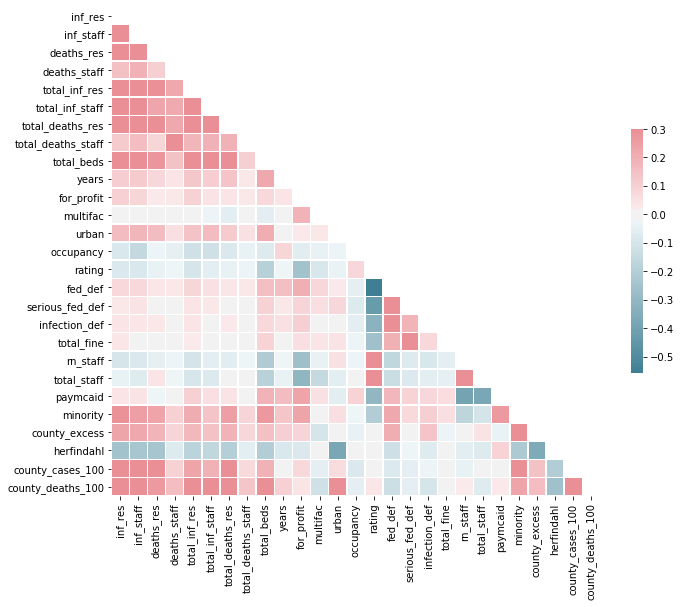

In [52]:
# Creating a correlation matrix
corr = df_merged.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Setting up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generating a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Drawing the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 7 Predictive Modeling

### 7.1 Data wrangling

#### 7.1.1 Select Target Variables

In [53]:
# Dropping other target variables since inf_res is the target variable for this model
df_merged = df_merged.drop(['inf_staff',
                            'deaths_res',
                            'deaths_staff',
                            'total_inf_res',
                            'total_inf_staff',
                            'total_deaths_res',
                            'total_deaths_staff'
                           ],axis=1)

In [54]:
# Dropping the multifac variable due to the lack of statistical significance demonstrated 
# in the univarate and bivariate analyses
df_merged = df_merged.drop(['multifac'
                           ],axis=1)

####  <font color='grey'>7.1.3 Encode Target Variablen (Not applied)</font>

Not required as the target variables are already encoded in the previous transformation process.

#### 7.1.4 Split Data Frame into Independent and Dependent Variables

In [55]:
# Splitting the data into independent 'X' and dependent 'Y' variables
X = df_merged.drop(columns=['inf_res']).values
Y = df_merged.filter(['inf_res']).values

#### 7.1.5 Split Data Frame in Training and Testing Data

In [56]:
# Splitting the data set into 80% training data and 20% testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#### 7.1.6 Scale Data

In [57]:
# Scaling the data to bring all features to the same level of magnitude
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 7.2 Select Model

#### 7.2.1 Machine Learning Models

The following section evaluates a total of six machine learning models (Logistic Regression, Nearest Neighbor, Support Vector Machine, Naïve Bayes, Decision Tree, Random Forest). The stacking model in which different machine learning models are combined is not used due to its poor performance and time consuming calculations.

In [58]:
# Creating a list of models to evaluate
def get_models():
    models = dict()
    models['log'] = LogisticRegression(random_state=0)
    models['knn'] = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
    models['svc_lin'] = SVC(kernel='linear',random_state=0)
    models['gauss'] = GaussianNB()
    models['tree'] = DecisionTreeClassifier(criterion='entropy',random_state=0)
    models['forest'] = RandomForestClassifier(n_estimators=100,max_features='auto',oob_score=True,random_state=1,n_jobs=-1)
    #models['stacking'] = get_stacking()
    return models

# Creating a function to evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
    scores = cross_val_score(model,X,Y,scoring='accuracy',cv=10)
    return scores

# Assigning the models to evaluate
models = get_models()

# Evaluating the models
model_results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model,X_train,Y_train)
    model_results.append(scores)
    names.append(name)
    print('>%s %.4f (%.4f)' % (name, mean(scores), std(scores)))

# Saving the results of all models including the stacking ensemble in order to save time to reproduce the results 
np.save('model_results.npy', model_results)

>log 0.7376 (0.0134)
>knn 0.7033 (0.0141)
>svc_lin 0.7372 (0.0146)
>gauss 0.6918 (0.0143)
>tree 0.6686 (0.0168)
>forest 0.7457 (0.0109)


In [59]:
# Loading the results and assigning the model names to the variable names
model_results = np.load('model_results.npy').tolist()
names = ['log','knn','svc_lin','gauss','tree','forest']

#### 7.2.2 Keras Neural Network

In [60]:
fold_no = 1
keras_results = list()
scores = []

for idx in KFold(n_splits=10).split(X_train):

    # Defining the keras model
    model = Sequential()
    model.add(Dense(16, input_dim=18, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compiling the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fitting the keras model on the dataset
    history = model.fit(X_train[idx[0]],Y_train[idx[0]],validation_data=(X_test,Y_test),epochs=100,batch_size=150,verbose=0)

    # Applying a k-fold validation of the data set
    score = model.evaluate(X_train[idx[1]],Y_train[idx[1]],verbose=1)
    scores.append(score[1])

    # Increasing fold number by 1
    fold_no = fold_no + 1
    
    name = 'keras'
    print('>%s %.4f (%.4f)' % (name, mean(scores), std(scores)))

scores = np.array(scores)
keras_results.append(np.array(scores))

name = 'keras'
print('>%s %.4f (%.4f)' % (name, mean(scores), std(scores)))

# Saving the results of all models including the stacking ensemble in order to save time to reproduce the results 
np.save('keras_results.npy', keras_results)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

1046/1046 [==============================] - 0s 16us/step
>keras 0.7505 (0.0000)
1046/1046 [==============================] - 0s 15us/step
>keras 0.7328 (0.0177)
1046/1046 [==============================] - 0s 17us/step
>keras 0.7333 (0.0145)
1046/1046 [==============================] - 0s 16us/step
>keras 0.7349 (0.0129)
1046/1046 [==============================] - 0s 16us/step
>keras 0.7390 (0.0141)
1046/1046 [==============================] - 0s 15us/step
>keras 0.7408 (0.0134)
1045/1045 [==============================] - 0s 16us/step
>keras 0.7457 (0.0173)
1045/1045 [==============================] - 0s 17us/step
>keras 0.7440 (0.0168)
1045/1045 [==============================] - 0s 18us/step
>keras 0.7413 (0.0176)
1045/1045 [==============================] - 0s 17us/step
>keras 0.7423 (0.0169)
>keras 0.7423 (0.0169)


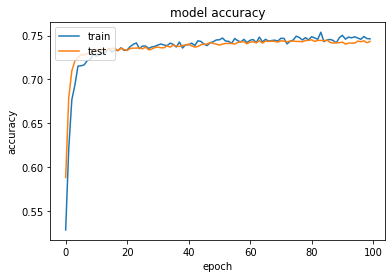

In [61]:
# Visualising the model accuracy
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [62]:
# Loading the results
keras_results = np.load('keras_results.npy').tolist()

#### 7.2.9 Model Comparison

In [63]:
# Combining the results of the models
model_results.append(keras_results[0])
names.append('keras')

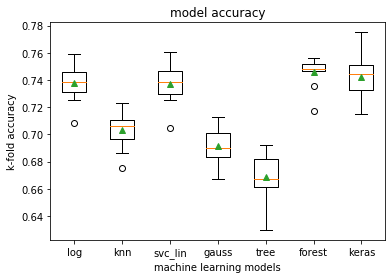

In [64]:
# Plotting performance of models for comparison
plt.boxplot(model_results, labels=names, showmeans=True)
plt.title('model accuracy')
plt.ylabel('k-fold accuracy')
plt.xlabel('machine learning models') 
plt.show()

### 7.3 Tree Based Feature Selection

#### 7.3.1 Random Forest Classification Algorithm

In [65]:
# Running the random forest classification algorithm again as only the results were saved in the previous steps
forest = RandomForestClassifier(n_estimators=100,max_features='auto',oob_score=True,random_state=1,n_jobs=-1)
forest.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

#### 7.3.2 Determine Feature Importance

Text(0, 0.5, 'feature importance')

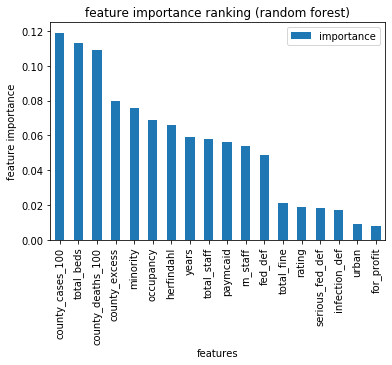

In [66]:
# Determining the 20 most important features for the chosen machine learning model
importances = pd.DataFrame({'features':df_merged.drop(columns=['inf_res']).columns,
                            'importance':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('features')
importances.head(20).plot.bar()
plt.title('feature importance ranking (random forest)')
plt.ylabel('feature importance')

#### 7.3.3 Drop Least Important Features

In [67]:
# Dropping features due to a lack of statistical importance for the model
# County Cases and Deaths are dropped as they include also cases from nursing homes and thus artificially 
# improve the models performance
df_merged = df_merged.drop(['for_profit',
                            'urban',
                            'rating',
                            'serious_fed_def',
                            'infection_def',
                            'total_fine',
                            #'county_cases_100',
                            #'county_deaths_100',
                           ],axis=1)

### 7.4 Data Wrangling of Data Frame with Important Features

#### 7.4.1 Split Data Frame into Independent and Dependent Variables

In [68]:
# Splitting the data into independent 'X' and dependent 'Y' variables
X_short = df_merged.drop(columns=['inf_res']).values
Y_short = df_merged.filter(['inf_res']).values

#### 7.4.2 Split Data Frame in Training and Testing Data

In [69]:
# Splitting the data set into 80% training data and 20% testing data
X_train_short, X_test_short, Y_train_short, Y_test_short = train_test_split(X_short, Y_short, test_size = 0.2, random_state = 0)

#### 7.4.3 Scale Data

In [70]:
# Scaling the data to bring all features to the same level of magnitude
sc = StandardScaler()
X_train_short = sc.fit_transform(X_train_short)
X_test_short = sc.transform(X_test_short)

### 7.5 Hyperparameter Tuning (Random Forest Classification Algorithm)

### 7.6 Run Random Forest Classification Algorithm

In [71]:
# Creating a list of models to evaluate
def get_models():
    models = dict()
    models['forest'] = RandomForestClassifier(n_estimators=1500,criterion='gini',min_samples_split=2,min_samples_leaf=5)
    return models

# Creating a function to evaluate a given model using cross-validation
def evaluate_model(model, X_train_short, Y_train_short):
    scores = cross_val_score(model,X_train_short,Y_train_short,scoring='accuracy',cv=10)
    return scores

# Assigning the models to evaluate
models = get_models()

# Evaluating the models
for name, model in models.items():
    scores = evaluate_model(model,X_train_short,Y_train_short)
    model_results.append(scores)
    names.append('forest2')
    print('>%s %.4f (%.4f)' % (name, mean(scores), std(scores)))

# Saving the results of all models including the stacking ensemble in order to save time to reproduce the results 
np.save('model_results2.npy', model_results)

>forest 0.7497 (0.0119)


In [72]:
# Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
forest = RandomForestClassifier(n_estimators=1500,criterion='gini',min_samples_split=2,min_samples_leaf=5)
forest.fit(X_train_short,Y_train_short)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [73]:
model_results2 = np.load('model_results2.npy').tolist()
names = ['log','knn','svc_lin','gauss','tree','forest','keras','forest2']

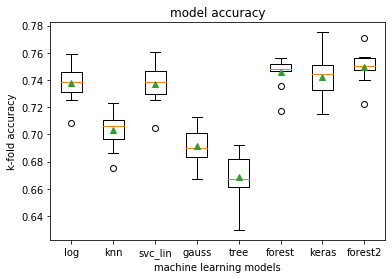

In [74]:
# Plotting performance of models for comparison
plt.boxplot(model_results2, labels=names, showmeans=True)
plt.title('model accuracy')
plt.ylabel('k-fold accuracy')
plt.xlabel('machine learning models') 
plt.show()

### 7.7 Evaluate Random Forest Classification Algorithm

#### 7.7.1 Confusion Matrix

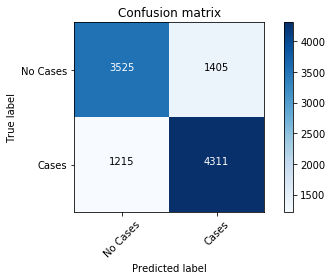

In [75]:
from sklearn.model_selection import cross_val_predict
# Creating a function to visualise a multi class confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylim(len(classes)-0.5,-0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Creating the multi class confusion matrix and applying the new function
predictions = cross_val_predict(forest, X_train_short, Y_train_short, cv=3)
cnf_matrix = confusion_matrix(Y_train, predictions)
np.set_printoptions(precision=2)

# Plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Cases','Cases'],
                      title='Confusion matrix')

In [76]:
# Printing additional evaluation scores
print("Precision:", round(precision_score(Y_train_short, predictions),4))
print("Recall:",round(recall_score(Y_train_short, predictions),4))
print("F1 Score:",round(f1_score(Y_train_short, predictions),4))

Precision: 0.7542
Recall: 0.7801
F1 Score: 0.7669


#### 7.7.2 Precision Recall Curve

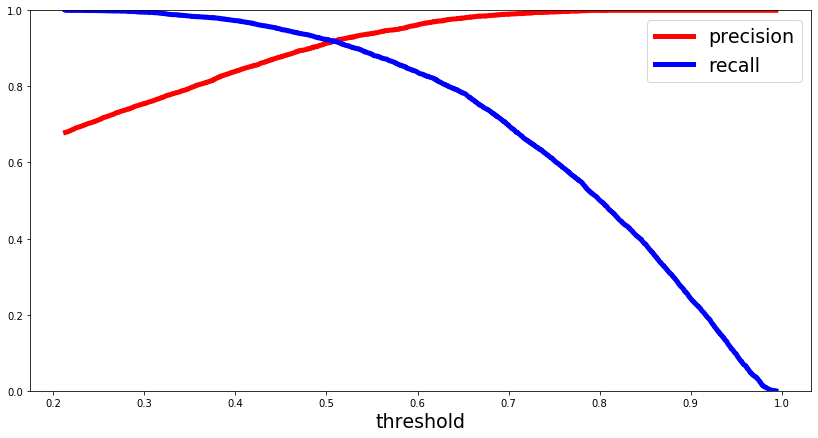

In [77]:
# Getting the probabilities of our predictions
y_scores = forest.predict_proba(X_train_short)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train_short, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

#### 7.7.3 ROC AUC Curve

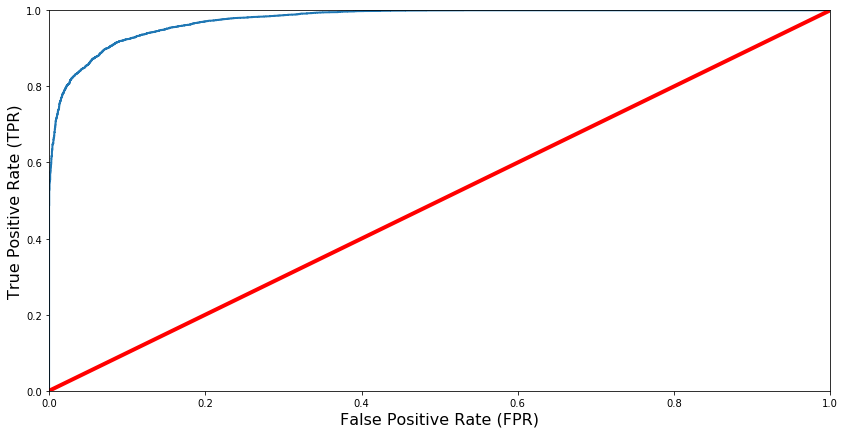

In [78]:
# Computing true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train_short, y_scores)

# Creating a function to plot them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

# Plotting them against each other
plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

#### 7.7.4 ROC AUC Score

In [79]:
# Calculating the ROC AUC Score
r_a_score = roc_auc_score(Y_train_short, y_scores)
print("ROC-AUC-Score:",round(r_a_score,4))

ROC-AUC-Score: 0.976


## 8 Model deployment (simplified concept with Random Forest Classification Algorithm)

In [80]:
# Creating a 12 question based questenair
print('Please answer the following 12 questions to determine if the selected nursing home is susceptible to infections.')

# Creating input fields
total_beds = int(input('Enter the total number of certified beds:'))
years = float(input('Enter the number of years the nursing home has been in operation:'))
occupancy = float(input('Enter the proportion of occupied beds:'))
fed_def = int(input('Enter the total number of federal deficiencies within the last 36 months:'))
rn_staff = float(input('Enter the average staffing levels of registered nurses per hours per resident day:'))
total_staff = float(input('Enter the average total staffing levels per hours per resident day:'))
paymcaid = float(input('Enter the proportion of facility residents whose primary support is Medicaid:'))
minority = float(input('Enter the proportion of facility residents who are not white:'))
county_excess = int(input('Enter the total number of beds available in the respective county:'))
herfindahl = float(input('Enter the herfindahl index of the respective nursing home:'))
county_cases_100 = int(input('Enter the total number of confirmed infection in the county:'))
county_deaths_100 = int(input('Enter the total number of confirmed fatalities in the county:'))

target = [[total_beds,
           years,
           occupancy,
           fed_def,
           rn_staff,
           total_staff,
           paymcaid,
           minority,
           county_excess,
           herfindahl,
           county_cases_100,
           county_deaths_100]]

pred = forest.predict(target)

if pred[0] == 0:
    print('The selected nursing home is not susceptible to COVID-19 infections.')
else:
    print('The selected nursing home is susceptible to COVID-19 infections.')

Please answer the following 12 questions to determine if the selected nursing home is susceptible to infections.
Enter the total number of certified beds:70
Enter the number of years the nursing home has been in operation:19.92
Enter the proportion of occupied beds:68.57
Enter the total number of federal deficiencies within the last 36 months:7
Enter the average staffing levels of registered nurses per hours per resident day:0.39
Enter the average total staffing levels per hours per resident day:2.52
Enter the proportion of facility residents whose primary support is Medicaid:50
Enter the proportion of facility residents who are not white:12.5
Enter the total number of beds available in the respective county:27
Enter the herfindahl index of the respective nursing home:50.04
Enter the total number of confirmed infection in the county:1218
Enter the total number of confirmed fatalities in the county:65
The selected nursing home is susceptible to COVID-19 infections.
